Simple SIR model of workplace:

Population 1 is drivers

Population 2 is onsite staff

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import Gillespie_package_SEIR as StochSim
import pandas as pd
import datetime as dt
import matplotlib

matplotlib.rcParams.update({'font.size': 12})

Define SEIR model for workplace consisting of 3 populations + package population

Only account for infections at the depot.

Nu or beta is infection rate between employees at the depot, assume this is the same regardless of role.

Assume drivers only spend t1 or tD proportion of their working day at the depot, hence driver-driver interaction goes as t1^2, while driver-onsite interaction as t1.

Gamma is recovery rate, here we use the average between a proportion that go into isolation, and a proportion that don't.

ND is proportion of workforce in driver population

Code to calculate critical values:

These numbers are broad stroke estimates from either DHL data or literature

In [2]:
ND = 50
NL = 15
NO = 10
gamma = 1/3
sigma = 1/5
FOI = 0
SAR = 0.05
alphaT = 0.2
alphaC = 0.2
td = 0.5
Network1 = StochSim.SEIR_package_model_Gillespie(Ndays=100, occupancy=[1], incidence_frac=[FOI], infection_probs=SAR, wp_contact_rate=[20], \
                            td=td, alphaT=alphaT, alphaC=alphaC, sigma=sigma, gamma=gamma, cross_contact_rate = 1, parcels_per_day=[3000], \
                            del_hlife = 0.25, virus_hlife=0.1)
Jh = Network1.fill_SEI_disease_free_Jacobian([ND,NL,NO])
print(Jh)

[[-2.00000000e-01  0.00000000e+00  0.00000000e+00  3.41955296e-01
   3.41955296e-01  3.41955296e-01  4.00000000e-03]
 [ 0.00000000e+00 -2.00000000e-01  0.00000000e+00  1.02586589e-01
   2.05173178e-01  2.05173178e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.00000000e-01  6.83910592e-02
   1.36782118e-01  1.36782118e-01  0.00000000e+00]
 [ 2.00000000e-01  0.00000000e+00  0.00000000e+00 -3.33333333e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.00000000e-01  0.00000000e+00  0.00000000e+00
  -3.33333333e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.00000000e-01  0.00000000e+00
   0.00000000e+00 -3.33333333e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.00000000e+03  0.00000000e+00 -9.70406053e+00]]


In [3]:
Eigs = np.zeros((11,11,11))
JEigs = np.zeros((11,11,11))
for i in np.arange(11):
    NC = i*3
    for j in np.arange(11):
        alphaT = j*0.05
        alphaC = j*0.05
        for k in np.arange(11):
            td = k*0.1
            Network = StochSim.SEIR_package_model_Gillespie(Ndays=1, occupancy=[1], incidence_frac=[0], infection_probs=SAR, \
                                                            wp_contact_rate=[NC], td=td, alphaT=alphaT, alphaC=alphaC, sigma=sigma,\
                                                            gamma=gamma, cross_contact_rate = 1, parcels_per_day=[3000],\
                                                            del_hlife = 0.5, virus_hlife=0.1)
            J = Network.fill_SEI_disease_free_Jacobian([ND,NL,NO])
            evals = np.linalg.eig(J)[0]
            JEigs[i,j,k] = np.max(np.real(evals))

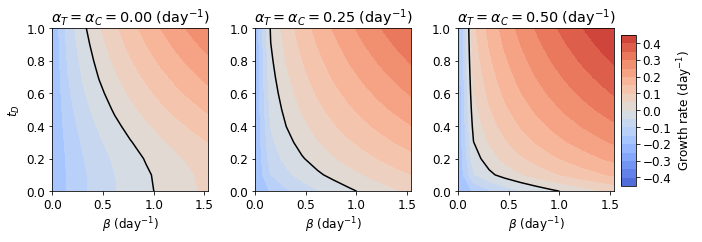

In [52]:
#do colormaps of eigenvalues
fig,ax = plt.subplots(1,3,figsize=(10,3))
Y,X = np.meshgrid(np.arange(11)*0.1,-np.arange(11)*3*np.log(1-SAR))
for i in np.arange(3):
    alpha = i*0.25
    c = ax[i].contourf(X,Y,JEigs[:,5*i,:],np.arange(-9,10)*0.05,cmap=cm.coolwarm)
    c.set_clim((-.5,.5))
    ax[i].contour(X,Y,JEigs[:,5*i,:],[0.0],colors=['k'])
    ax[i].set_xlabel('$\\beta$ (day$^{-1}$)')
    
    ax[i].set_title('$\\alpha_T = \\alpha_C = $%.2f (day$^{-1}$)'%alpha)
ax[0].set_ylabel('$t_D$')
fig.subplots_adjust(left=0.08,right=0.86,wspace = 0.3)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
cb = fig.colorbar(c, cax=cbar_ax)
cb.set_label('Growth rate (day$^{-1}$)')
fig.savefig('J_eigenvals_SEIR.png')

Random example simulation

In [5]:
dtime = 0.1
S,E,I,R,P = Network1.run_deterministic_sim([ND,NL,NO],[0,1,0],dtime)

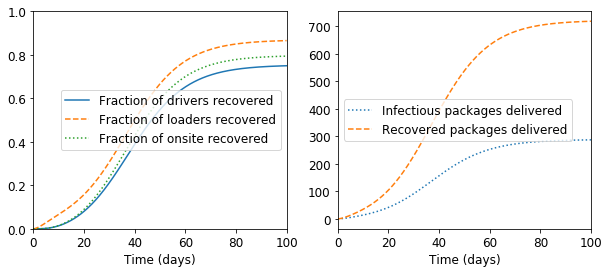

In [6]:
Nt = len(S[0,:])
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P)[:,3],':',color='C0',label='Infectious packages delivered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P)[:,4],'--',color='C1',label='Recovered packages delivered')
ax[0].set_ylim((0,1))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,100))
    ax[i].set_xlabel('Time (days)')

In [23]:
PrevData = pd.read_csv('UKPrevalence.csv')
Pdates = []
Pdelta = []
for d in PrevData['Date']:
    Pdates.append(dt.datetime.strptime(d,'%d/%m/%Y'))
    Pd = (Pdates[-1] - dt.datetime.strptime('01/01/20','%d/%m/%y'))
    Pdelta.append(Pd.days)
PrevData['DatePython'] = Pdates
PrevData['DateDelta'] = Pdelta
prevalence = np.append(np.zeros(PrevData['DateDelta'][0]),np.array(PrevData['incidence']))
cum_prev = np.append(np.zeros(PrevData['DateDelta'][0]),np.array(PrevData['cumulative incidence']))
UKpop0 = PrevData['cumulative incidence']/PrevData['cumulative fraction']
print(PrevData)

           Date      incidence  cumulative incidence  cumulative fraction  \
0    06/02/2020       7.580131          7.580131e+00         1.353590e-07   
1    07/02/2020       9.125539          1.670567e+01         2.983160e-07   
2    08/02/2020      11.031131          2.773680e+01         4.953000e-07   
3    09/02/2020      13.519321          4.125612e+01         7.367160e-07   
4    10/02/2020      16.765540          5.802166e+01         1.036100e-06   
..          ...            ...                   ...                  ...   
314  16/12/2020  643104.557800          2.795245e+07         4.991509e-01   
315  17/12/2020  640777.904800          2.859323e+07         5.105934e-01   
316  18/12/2020  637437.577900          2.923067e+07         5.219762e-01   
317  19/12/2020  633076.758500          2.986374e+07         5.332811e-01   
318  20/12/2020  627491.969700          3.049124e+07         5.444864e-01   

    DatePython  DateDelta  
0   2020-02-06         36  
1   2020-02-07     

Find steady state values for R and S in each compartment and expression for total number of infected packages delivered.

Text(0, 0.5, 'New infections (\\% of population)')

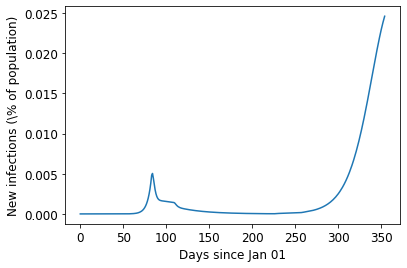

In [8]:
UKpop = np.append(np.ones(PrevData['DateDelta'][0])*UKpop0[0],UKpop0)
incidence = prevalence/UKpop
incidenceS = prevalence/(UKpop - cum_prev)
plt.plot(incidenceS)
plt.xlabel('Days since Jan 01')
plt.ylabel('New infections (\% of population)')

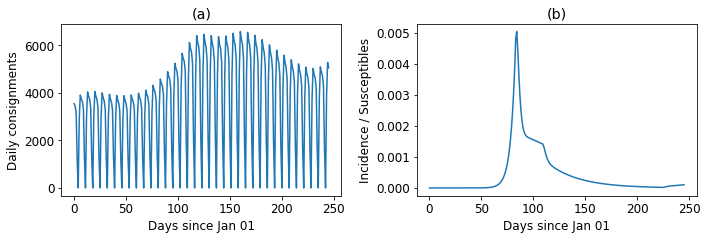

In [9]:
df = pd.read_pickle('DHL_parcel_demand.pkl')
nb1 = pd.read_pickle('Weekday_demand_fit_DHLP.pkl')
nb2 = pd.read_pickle('Site_demand_fit_DHLP.pkl')
nb3 = pd.read_pickle('Weekday_demand_driverfit_DHLP.pkl')

dc = float(nb1['Coeffs'][nb1['Params']=='DEMAND'])
Weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
WDcoeffs0 = np.zeros(7)
for i in np.arange(7):
    for p in nb1['Params']:
        if Weekday[i] in p:
            WDcoeffs0[i] = nb1['Coeffs'][nb1['Params']==p]
demand = df['Demand'].to_numpy()
DOW = np.zeros(len(demand),dtype=np.int)
j = 0
for d in df['Dates']:
    dp = dt.datetime.strptime(d,'%d/%m/%y')
    DOW[j] = int(dp.weekday())
    j += 1
WDcoeffs = np.exp(WDcoeffs0)
WDcoeffs[6] = 0
mu = np.exp(float(nb1['Coeffs'][nb1['Params']=='Intercept']))*np.exp(dc*demand)*WDcoeffs[DOW]



site_coeffs = []
for p in nb2['Params']:
    if 'SITE' in p:
        site_coeffs.append(float(nb2['Coeffs'][nb2['Params']==p]))

mu_site = np.zeros((len(site_coeffs),len(mu)))
esc = np.exp(site_coeffs)
esc_sum = np.sum(esc)
overdisp = 0.02

occ = np.ones(len(mu))
occ[DOW==5] = 0.5
occ[DOW==6] = 0

avsite_demand = mu/52
fig,ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(avsite_demand)
ax[1].plot(incidenceS[:len(mu)])
ax[0].set_xlabel('Days since Jan 01')
ax[1].set_xlabel('Days since Jan 01')
ax[0].set_ylabel('Daily consignments')
ax[1].set_ylabel('Incidence / Susceptibles')
ax[0].set_title('(a)')
ax[1].set_title('(b)')
fig.tight_layout()
fig.savefig('demand_inc.png')

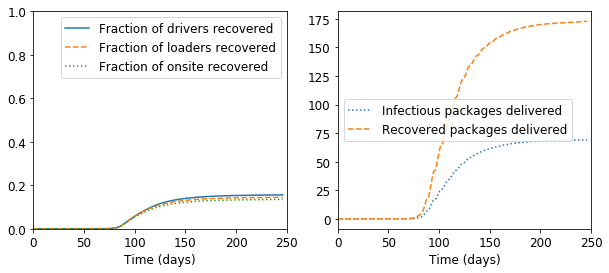

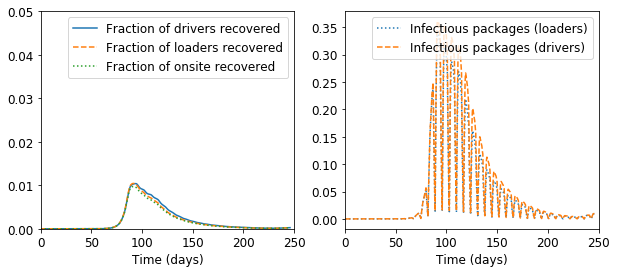

In [27]:
dtime = 0.1
ND = 50
NL = 15
NO = 10
gamma = 1/3
sigma = 1/5
FOI = 0
SAR = 0.05
alphaT = 0.2
alphaC = 0.2
td = 0.2
Ndays = len(avsite_demand)
Network1 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=occ, incidence_frac=incidenceS[:Ndays], infection_probs=SAR,\
                                                 wp_contact_rate=[5], td=td, alphaT=alphaT, alphaC=alphaC, sigma=sigma, gamma=gamma, \
                                                 cross_contact_rate = 1, parcels_per_day=avsite_demand, del_hlife = 0.25, virus_hlife=0.1)
S1,E1,I1,R1,P1 = Network1.run_deterministic_sim([ND,NL,NO],[0,0,0],dtime)
Nt = len(S1[0,:])
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P1)[:,3],':',color='C0',label='Infectious packages delivered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P1)[:,4],'--',color='C1',label='Recovered packages delivered')
ax[0].set_ylim((0,1))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,250))
    ax[i].set_xlabel('Time (days)')

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I1)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I1)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I1)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P1)[:,1],':',color='C0',label='Infectious packages (loaders)')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P1)[:,2],'--',color='C1',label='Infectious packages (drivers)')
ax[0].set_ylim((0,0.05))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,250))
    ax[i].set_xlabel('Time (days)')

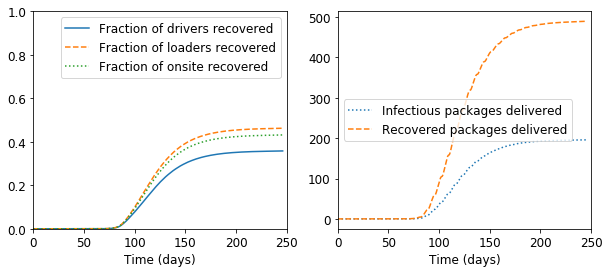

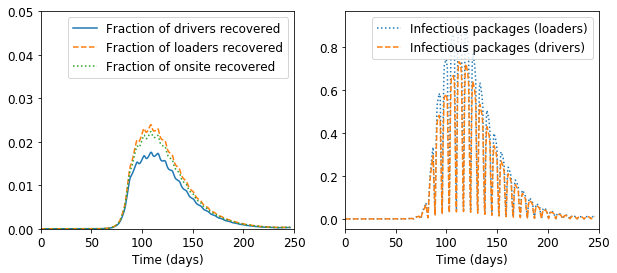

In [28]:
Network2 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=occ, incidence_frac=incidenceS[:Ndays], infection_probs=SAR,\
                                                 wp_contact_rate=[20], td=td, alphaT=alphaT, alphaC=alphaC, sigma=sigma, gamma=gamma, \
                                                 cross_contact_rate = 1, parcels_per_day=avsite_demand, del_hlife = 0.25, virus_hlife=0.1)
S2,E2,I2,R2,P2 = Network2.run_deterministic_sim([ND,NL,NO],[0,0,0],dtime)

Nt = len(S2[0,:])
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P2)[:,3],':',color='C0',label='Infectious packages delivered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P2)[:,4],'--',color='C1',label='Recovered packages delivered')
ax[0].set_ylim((0,1))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,250))
    ax[i].set_xlabel('Time (days)')

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I2)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I2)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I2)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P2)[:,1],':',color='C0',label='Infectious packages (loaders)')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P2)[:,2],'--',color='C1',label='Infectious packages (drivers)')
ax[0].set_ylim((0,0.05))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,250))
    ax[i].set_xlabel('Time (days)')

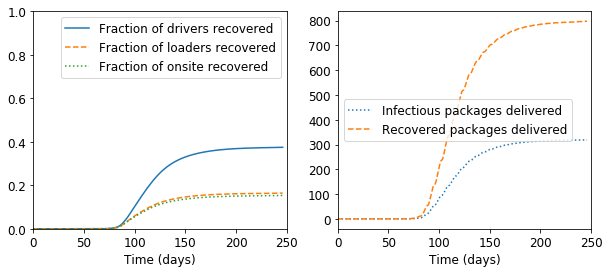

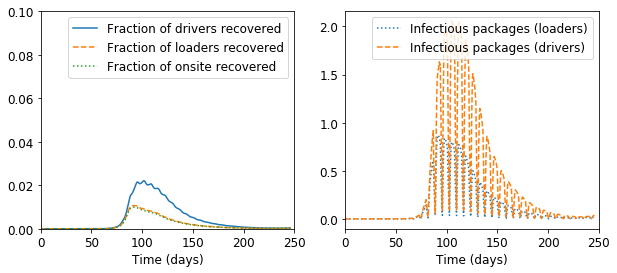

In [29]:
alphaC=0.5
alphaT=0.5
Network3 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=occ, incidence_frac=incidenceS[:Ndays], infection_probs=SAR,\
                                                 wp_contact_rate=[5], td=td, alphaT=alphaT, alphaC=alphaC, sigma=sigma, gamma=gamma, \
                                                 cross_contact_rate = 1, parcels_per_day=avsite_demand, del_hlife = 0.25, virus_hlife=0.1)
S3,E3,I3,R3,P3 = Network3.run_deterministic_sim([ND,NL,NO],[0,0,0],dtime)

Nt = len(S3[0,:])
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P3)[:,3],':',color='C0',label='Infectious packages delivered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P3)[:,4],'--',color='C1',label='Recovered packages delivered')
ax[0].set_ylim((0,1))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,250))
    ax[i].set_xlabel('Time (days)')

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I3)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I3)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I3)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P3)[:,1],':',color='C0',label='Infectious packages (loaders)')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P3)[:,2],'--',color='C1',label='Infectious packages (drivers)')
ax[0].set_ylim((0,0.1))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,250))
    ax[i].set_xlabel('Time (days)')

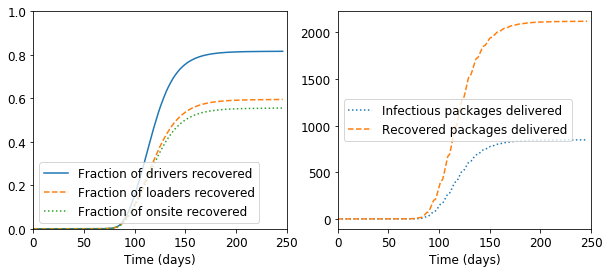

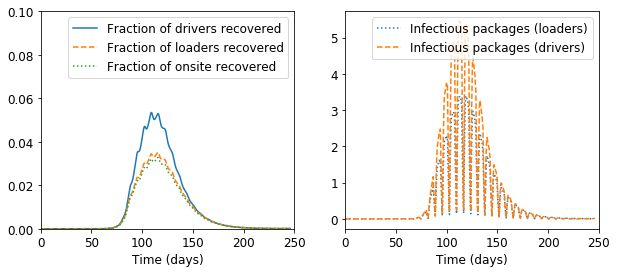

In [30]:
alphaC=0.5
alphaT=0.5
Network4 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=occ, incidence_frac=incidenceS[:Ndays], infection_probs=SAR,\
                                                 wp_contact_rate=[20], td=td, alphaT=alphaT, alphaC=alphaC, sigma=sigma, gamma=gamma, \
                                                 cross_contact_rate = 1, parcels_per_day=avsite_demand, del_hlife = 0.25, virus_hlife=0.1)
S4,E4,I4,R4,P4 = Network4.run_deterministic_sim([ND,NL,NO],[0,0,0],dtime)

Nt = len(S4[0,:])
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P4)[:,3],':',color='C0',label='Infectious packages delivered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P4)[:,4],'--',color='C1',label='Recovered packages delivered')
ax[0].set_ylim((0,1))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,250))
    ax[i].set_xlabel('Time (days)')

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I4)[:,0]/S[0,0],color='C0',label='Fraction of drivers recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I4)[:,1]/S[1,0],'--',color='C1',label='Fraction of loaders recovered')
ax[0].plot(np.arange(Nt)*dtime,np.transpose(I4)[:,2]/S[2,0],':',color='C2',label='Fraction of onsite recovered')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P4)[:,1],':',color='C0',label='Infectious packages (loaders)')
ax[1].plot(np.arange(Nt)*dtime,np.transpose(P4)[:,2],'--',color='C1',label='Infectious packages (drivers)')
ax[0].set_ylim((0,0.1))
for i in np.arange(2):
    ax[i].legend()
    ax[i].set_xlim((0,250))
    ax[i].set_xlabel('Time (days)')

[5.85478023e+01 5.73698799e-02 5.73543626e-02 2.40505347e+02
 6.01263367e+02] [5.86055806e+01 7.52878931e-02 3.23234167e-02 1.02597394e+03
 2.56493484e+03]


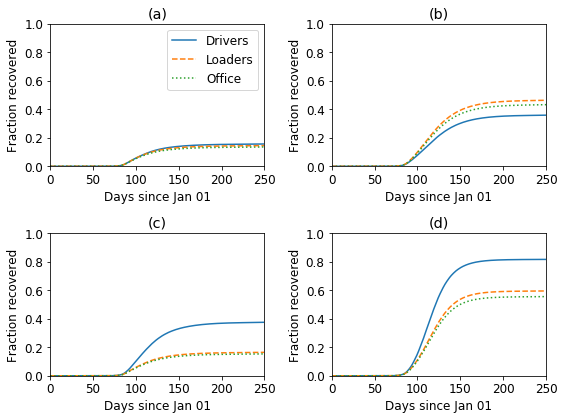

In [36]:
fig, ax = plt.subplots(2,2,figsize=(8,6))
ax[0,0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,0]/S[0,0],color='C0',label='Drivers')
ax[0,0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,1]/S[1,0],'--',color='C1',label='Loaders')
ax[0,0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,2]/S[2,0],':',color='C2',label='Office')
ax[0,1].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,0]/S[0,0],color='C0')
ax[0,1].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,1]/S[1,0],'--',color='C1')
ax[0,1].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,2]/S[2,0],':',color='C2')
ax[1,0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,0]/S[0,0],color='C0')
ax[1,0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,1]/S[1,0],'--',color='C1')
ax[1,0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,2]/S[2,0],':',color='C2')
ax[1,1].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,0]/S[0,0],color='C0')
ax[1,1].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,1]/S[1,0],'--',color='C1')
ax[1,1].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,2]/S[2,0],':',color='C2')
titles=['(a)','(b)','(c)','(d)']
for i in np.arange(2):
    for j in np.arange(2):
        ax[i,j].set_xlabel('Days since Jan 01')
        ax[i,j].set_ylabel('Fraction recovered')
        ax[i,j].set_xlim((0,250))
        ax[i,j].set_ylim((0,1))
        ax[i,j].set_title(titles[i*2+j])
ax[0,0].legend()
fig.tight_layout()
fig.savefig('scenarios.png')

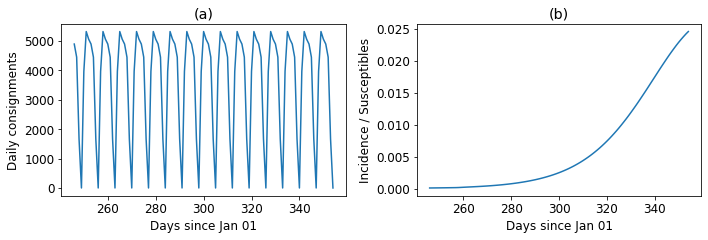

In [37]:
lastdemand = df['Demand'].to_numpy()[-1]
futuredemand = np.ones(len(incidenceS) - len(mu))*lastdemand
DOWf = np.zeros(len(futuredemand),dtype=np.int)
jan01 = dt.datetime.strptime("01/01/20",'%d/%m/%y')
for i in np.arange(len(mu),len(mu) + len(futuredemand)):
    dp = jan01 + dt.timedelta(days=int(i))
    
    DOWf[i-len(mu)] = int(dp.weekday())
WDcoeffs = np.exp(WDcoeffs0)
WDcoeffs[6] = 0
muf = np.exp(float(nb1['Coeffs'][nb1['Params']=='Intercept']))*np.exp(dc*futuredemand)*WDcoeffs[DOWf]
future_occ = np.ones(len(muf))
future_occ[DOWf==5] = 0.5
future_occ[DOWf==6] = 0
future_avsite_demand = muf/52
fig,ax = plt.subplots(1,2,figsize=(10,3.5))
ax[0].plot(np.arange(len(mu),len(mu) + len(muf)),future_avsite_demand)
ax[1].plot(np.arange(len(mu),len(mu) + len(muf)),incidenceS[len(mu):])
ax[0].set_xlabel('Days since Jan 01')
ax[1].set_xlabel('Days since Jan 01')
ax[0].set_ylabel('Daily consignments')
ax[1].set_ylabel('Incidence / Susceptibles')
ax[0].set_title('(a)')
ax[1].set_title('(b)')
fig.tight_layout()
fig.savefig('future_demand_inc.png')

In [38]:
alphaC=0.2
alphaT=0.2
Ndays = len(mu) + len(muf)
Network1 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=np.append(occ,future_occ), incidence_frac=incidenceS,\
                                                 infection_probs=SAR, wp_contact_rate=[5], td=td, alphaT=alphaT, alphaC=alphaC,\
                                                 sigma=sigma, gamma=gamma, cross_contact_rate = 1, \
                                                 parcels_per_day=np.append(avsite_demand,future_avsite_demand),\
                                                 del_hlife = 0.25, virus_hlife=0.1)
S1,E1,I1,R1,P1 = Network1.run_deterministic_sim([ND,NL,NO],[0,0,0],dtime)

Network2 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=np.append(occ,future_occ), incidence_frac=incidenceS,\
                                                 infection_probs=SAR, wp_contact_rate=[20], td=td, alphaT=alphaT, alphaC=alphaC,\
                                                 sigma=sigma, gamma=gamma, cross_contact_rate = 1, \
                                                 parcels_per_day=np.append(avsite_demand,future_avsite_demand),\
                                                 del_hlife = 0.25, virus_hlife=0.1)
S2,E2,I2,R2,P2 = Network2.run_deterministic_sim([ND,NL,NO],[0,0,0],dtime)

alphaC=0.5
alphaT=0.5
Network3 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=np.append(occ,future_occ), incidence_frac=incidenceS,\
                                                 infection_probs=SAR, wp_contact_rate=[5], td=td, alphaT=alphaT, alphaC=alphaC,\
                                                 sigma=sigma, gamma=gamma, cross_contact_rate = 1, \
                                                 parcels_per_day=np.append(avsite_demand,future_avsite_demand),\
                                                 del_hlife = 0.25, virus_hlife=0.1)
S3,E3,I3,R3,P3 = Network3.run_deterministic_sim([ND,NL,NO],[0,0,0],dtime)

Network4 = StochSim.SEIR_package_model_Gillespie(Ndays=Ndays, occupancy=np.append(occ,future_occ), incidence_frac=incidenceS,\
                                                 infection_probs=SAR, wp_contact_rate=[20], td=td, alphaT=alphaT, alphaC=alphaC,\
                                                 sigma=sigma, gamma=gamma, cross_contact_rate = 1, \
                                                 parcels_per_day=np.append(avsite_demand,future_avsite_demand),\
                                                 del_hlife = 0.25, virus_hlife=0.1)
S4,E4,I4,R4,P4 = Network4.run_deterministic_sim([ND,NL,NO],[0,0,0],dtime)

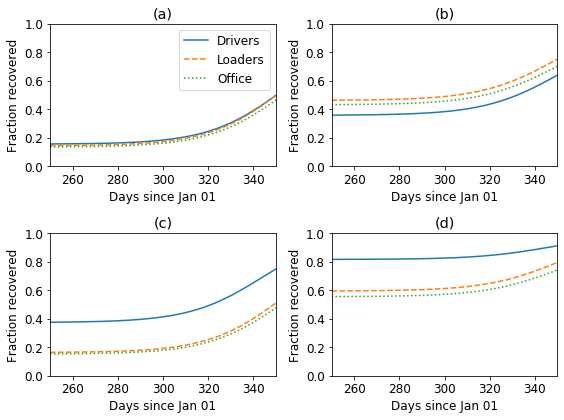

In [39]:
Nt = len(S1[0,:])
fig, ax = plt.subplots(2,2,figsize=(8,6))
ax[0,0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,0]/S[0,0],color='C0',label='Drivers')
ax[0,0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,1]/S[1,0],'--',color='C1',label='Loaders')
ax[0,0].plot(np.arange(Nt)*dtime,np.transpose(R1)[:,2]/S[2,0],':',color='C2',label='Office')
ax[0,1].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,0]/S[0,0],color='C0')
ax[0,1].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,1]/S[1,0],'--',color='C1')
ax[0,1].plot(np.arange(Nt)*dtime,np.transpose(R2)[:,2]/S[2,0],':',color='C2')
ax[1,0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,0]/S[0,0],color='C0')
ax[1,0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,1]/S[1,0],'--',color='C1')
ax[1,0].plot(np.arange(Nt)*dtime,np.transpose(R3)[:,2]/S[2,0],':',color='C2')
ax[1,1].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,0]/S[0,0],color='C0')
ax[1,1].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,1]/S[1,0],'--',color='C1')
ax[1,1].plot(np.arange(Nt)*dtime,np.transpose(R4)[:,2]/S[2,0],':',color='C2')
titles=['(a)','(b)','(c)','(d)']
for i in np.arange(2):
    for j in np.arange(2):
        ax[i,j].set_xlabel('Days since Jan 01')
        ax[i,j].set_ylabel('Fraction recovered')
        ax[i,j].set_xlim((250,350))
        ax[i,j].set_ylim((0,1))
        ax[i,j].set_title(titles[i*2+j])
ax[0,0].legend()
fig.tight_layout()
fig.savefig('future_scenarios.png')

In [47]:
print(P1[3,int(len(mu)/dtime)],P4[3,int(len(mu)/dtime)])

69.13923579158146 847.8781428716561
